In [123]:
import torch 
import numpy as np
from torch import nn
from torch.nn import functional as F
from sphere_initialization import generate_class_vectors
from sphere_initialization import generate_class_vectors_hemispheres
from siglip_loss import SigLIPLoss
from siglip_experiment import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Some Parameters

In [160]:
torch.manual_seed(50)

n_classes = 100
dim = 10
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'


initial_temperature = 10.0
initial_relative_bias = 0
initial_x= 0.5

delta = torch.sigmoid(torch.tensor(initial_x)).item()
initial_temperature_rescaled = initial_temperature /delta **2
initial_relative_bias_rescaled = initial_relative_bias*(delta**2)  -  + (1 - delta**2)

U0 = torch.randn(n_classes, dim, device = device_str)

# Without Explicit Adapter

In [161]:
print(f"Using device: {device_str}")
print(f"Running experiment with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")
print(f"Loss params: temperature={initial_temperature}, relative_bias={initial_relative_bias}, trainable_bias={bias_is_trainable}")

experiment = SigLIPExperiment(
    n_classes=n_classes,
    dim=dim,
    n_epochs=n_epochs,
    device=device_str,
    when_to_print = 5000
)

U_final, V_final, criterion_final, no_adapter_losses_history = experiment.train(
    relative_bias=initial_relative_bias,
    temperature=initial_temperature,
    trainable_bias=True,
    trainable_temp=True,
    fixed_U=U0,
    explicit_adapter=False
    )

print("\n--- Training Complete ---")
print(f"Final Loss: {no_adapter_losses_history[-1]:.4f}")
print(f"Final Temperature: {criterion_final.get_temperature():.4f}")
print(f"Final Bias Value: {criterion_final.get_bias():.4f}")

Using device: cpu
Running experiment with: n_classes=100, dim=10, n_epochs=10000
Loss params: temperature=10.0, relative_bias=0, trainable_bias=True
[5000/10000]  loss=0.0000  T=44.0607  rb=0.7606
[10000/10000]  loss=0.0000  T=63.6983  rb=0.7494

--- Training Complete ---
Final Loss: 0.0000
Final Temperature: 63.6983
Final Bias Value: 0.7494


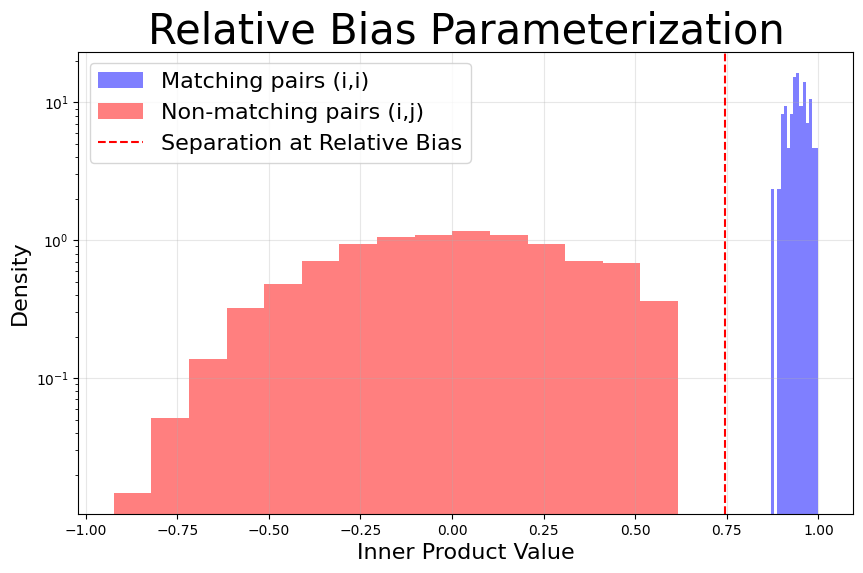

In [162]:
# Calculate all pairwise inner products
inner_products = torch.matmul(U_final, V_final.t())

# Get matching pairs (diagonal elements)
matching_pairs = torch.diag(inner_products).detach().cpu().numpy()

# Get non-matching pairs (off-diagonal elements)
mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
non_matching_pairs = inner_products[mask].detach().cpu().numpy()

# Create histogram plot
plt.figure(figsize=(10, 6))
plt.hist(matching_pairs, bins=15, alpha=0.5, label='Matching pairs (i,i)', color='blue', density=True)
plt.hist(non_matching_pairs, bins=15, alpha=0.5, label='Non-matching pairs (i,j)', color='red', density=True)

# Add red line showing separation between max non-matching and min matching
min_matching = np.min(matching_pairs)
max_non_matching = np.max(non_matching_pairs)
midpoint = (min_matching + max_non_matching) / 2
plt.axvline(x=midpoint, color='red', linestyle='--', label='Separation at Relative Bias')

plt.xlabel('Inner Product Value',fontsize=16)
plt.ylabel('Density',fontsize=16)
plt.title('Relative Bias Parameterization', fontsize=30)
plt.legend(fontsize= 16)
plt.grid(True, alpha=0.3)
plt.yscale("log")
plt.savefig('logs/frozen_modality_rb_ip_separation.png',dpi =300,  bbox_inches='tight')
plt.show()


# Experiments with Explicit Adapter

In [163]:
print(f"Using device: {device_str}")
print(f"Running experiment with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")
print(f"Loss params: temperature={initial_temperature}, relative_bias={initial_relative_bias}, trainable_bias={bias_is_trainable}")

experiment = SigLIPExperiment(
    n_classes=n_classes,
    dim=dim,
    n_epochs=n_epochs,
    device=device_str,
    when_to_print = 5000
)

U_final, V_final, criterion_final, with_adapter_losses_history, x_final = experiment.train(
    relative_bias=initial_relative_bias_rescaled,
    temperature=initial_temperature_rescaled,
    trainable_bias=True,
    trainable_temp=True,
    fixed_U=U0,
    explicit_adapter=True,
    initial_x=0.5
)

print("\n--- Training Complete ---")
print(f"Final Loss: {with_adapter_losses_history[-1]:.4f}")
print(f"Final Temperature: {criterion_final.get_temperature():.4f}")
print(f"Final Delta: {torch.sigmoid(x_final).item():.4f}")
print(f"Final Bias Value: {criterion_final.get_bias():.4f}")

Using device: cpu
Running experiment with: n_classes=100, dim=10, n_epochs=10000
Loss params: temperature=10.0, relative_bias=0, trainable_bias=True
[5000/10000]  loss=0.0000  δ=0.6320  T=202.5603  rb=-0.3480
[10000/10000]  loss=0.0000  δ=0.6418  T=338.6512  rb=-0.3273

--- Training Complete ---
Final Loss: 0.0000
Final Temperature: 338.6512
Final Delta: 0.6418
Final Bias Value: -0.3273


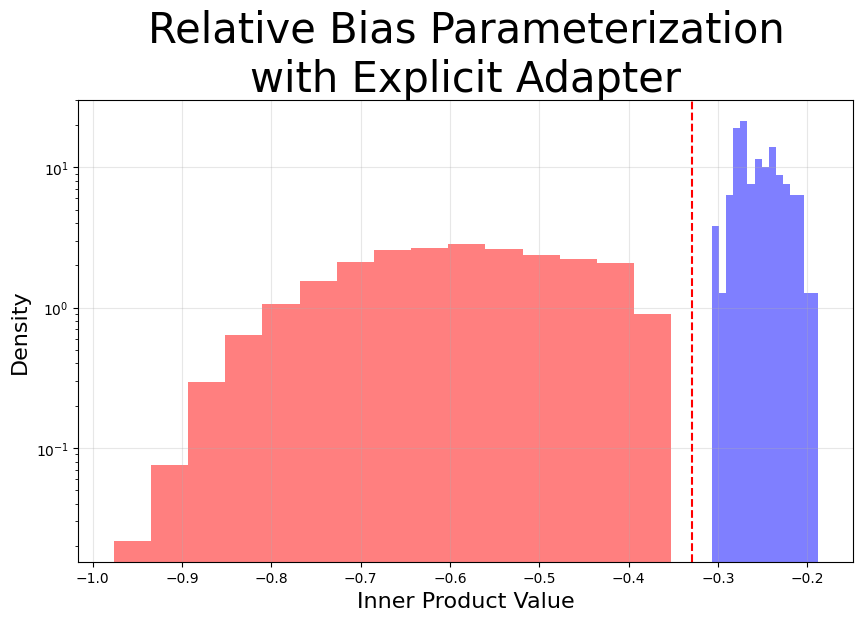

In [164]:
# Calculate all pairwise inner products
inner_products = torch.matmul(U_final, V_final.t())

# Get matching pairs (diagonal elements)
matching_pairs = torch.diag(inner_products).detach().cpu().numpy()

# Get non-matching pairs (off-diagonal elements)
mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
non_matching_pairs = inner_products[mask].detach().cpu().numpy()

# Create histogram plot
plt.figure(figsize=(10, 6))
plt.hist(matching_pairs, bins=15, alpha=0.5, label='Matching pairs (i,i)', color='blue', density=True)
plt.hist(non_matching_pairs, bins=15, alpha=0.5, label='Non-matching pairs (i,j)', color='red', density=True)

# Add red line showing separation between max non-matching and min matching
min_matching = np.min(matching_pairs)
max_non_matching = np.max(non_matching_pairs)
midpoint = (min_matching + max_non_matching) / 2
plt.axvline(x=midpoint, color='red', linestyle='--', label='Separation Point')

plt.title('Relative Bias Parameterization\nwith Explicit Adapter', fontsize=30)
plt.xlabel('Inner Product Value',fontsize=16)
plt.ylabel('Density',fontsize=16)
# plt.legend(fontsize= 16)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.savefig('logs/frozen_modality_with_adapter_ip_separation.png',dpi =300,  bbox_inches='tight')
plt.show()


# Training with Sigmoid loss without Relative Bias Parametrization

In [165]:
print(f"Using device: {device_str}")
print(f"Running experiment with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")
print(f"Loss params: temperature={initial_temperature}, relative_bias={initial_relative_bias}, trainable_bias={bias_is_trainable}")

experiment = SigLIPExperiment(
    n_classes=n_classes,
    dim=dim,
    n_epochs=n_epochs,
    device=device_str,
    relative_bias_parameterization= False,
    when_to_print = 5000
)

U_final, V_final, criterion_final, no_adapter_losses_history_non_rb = experiment.train(
    bias = initial_relative_bias*initial_temperature,
    temperature=initial_temperature,
    trainable_bias=True,
    trainable_temp=True,
    fixed_U=U0,
    explicit_adapter=False
    )

print("\n--- Training Complete ---")
print(f"Final Loss: {no_adapter_losses_history[-1]:.4f}")
print(f"Final Temperature: {criterion_final.get_temperature():.4f}")
print(f"Final Bias Value: {criterion_final.get_bias():.4f}")

Using device: cpu
Running experiment with: n_classes=100, dim=10, n_epochs=10000
Loss params: temperature=10.0, relative_bias=0, trainable_bias=True
[5000/10000]  loss=0.0053  T=12.1509  rb=0.7551
[10000/10000]  loss=0.0006  T=23.5252  rb=0.6990

--- Training Complete ---
Final Loss: 0.0000
Final Temperature: 23.5252
Final Bias Value: 16.4450


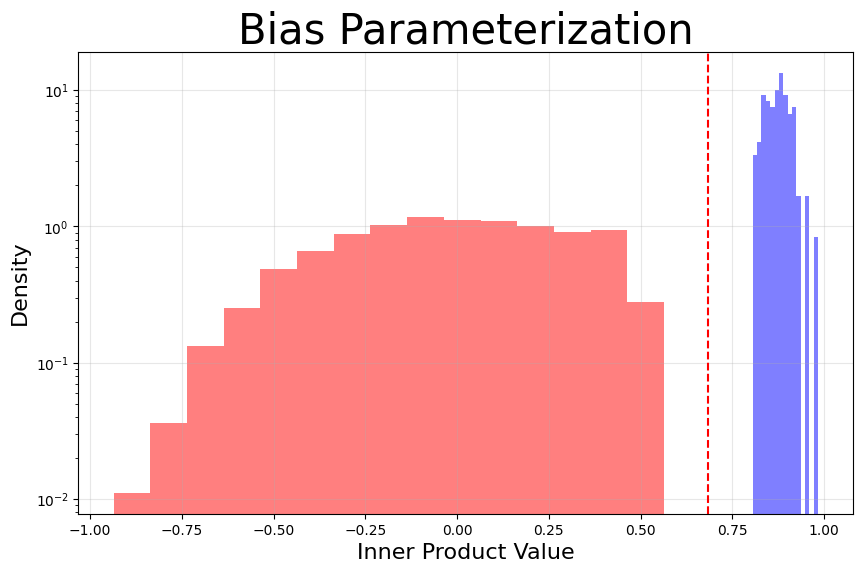

In [166]:
# Calculate all pairwise inner products
inner_products = torch.matmul(U_final, V_final.t())

# Get matching pairs (diagonal elements)
matching_pairs = torch.diag(inner_products).detach().cpu().numpy()

# Get non-matching pairs (off-diagonal elements)
mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
non_matching_pairs = inner_products[mask].detach().cpu().numpy()

# Create histogram plot
plt.figure(figsize=(10, 6))
plt.hist(matching_pairs, bins=15, alpha=0.5, label='Matching pairs (i,i)', color='blue', density=True)
plt.hist(non_matching_pairs, bins=15, alpha=0.5, label='Non-matching pairs (i,j)', color='red', density=True)

# Add red line showing separation between max non-matching and min matching
min_matching = np.min(matching_pairs)
max_non_matching = np.max(non_matching_pairs)
midpoint = (min_matching + max_non_matching) / 2
plt.axvline(x=midpoint, color='red', linestyle='--', label='Separation Point')

plt.xlabel('Inner Product Value',fontsize=16)
plt.ylabel('Density',fontsize=16)
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title('Bias Parameterization', fontsize=30)
plt.savefig('logs/frozen_modality_b_ip_separation.png',dpi =300,  bbox_inches='tight')
plt.show()


# Fixed Temperature and Bias

In [167]:
print(f"Using device: {device_str}")
print(f"Running experiment with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")
print(f"Loss params: temperature={initial_temperature}, relative_bias={initial_relative_bias}, trainable_bias={bias_is_trainable}")

experiment = SigLIPExperiment(
    n_classes=n_classes,
    dim=dim,
    n_epochs=n_epochs,
    device=device_str,
    relative_bias_parameterization= False,
    when_to_print = 5000
)

U_final, V_final, criterion_final, no_adapter_losses_history_non_rb_fixed = experiment.train(
    bias=initial_relative_bias*initial_temperature,
    temperature=initial_temperature,
    trainable_bias=False,
    trainable_temp=False,
    fixed_U=U0,
    explicit_adapter=False
    )

print("\n--- Training Complete ---")
print(f"Final Loss: {no_adapter_losses_history[-1]:.4f}")
print(f"Final Temperature: {criterion_final.get_temperature():.4f}")
print(f"Final Bias Value: {criterion_final.get_bias():.4f}")

Using device: cpu
Running experiment with: n_classes=100, dim=10, n_epochs=10000
Loss params: temperature=10.0, relative_bias=0, trainable_bias=True
[5000/10000]  loss=0.8238  T=10.0000  rb=0.0000
[10000/10000]  loss=0.8238  T=10.0000  rb=0.0000

--- Training Complete ---
Final Loss: 0.0000
Final Temperature: 10.0000
Final Bias Value: 0.0000


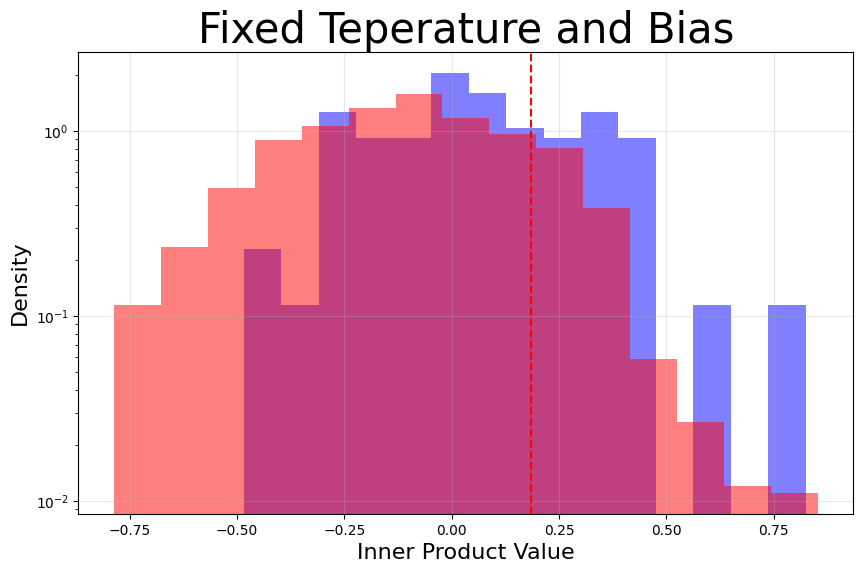

In [168]:
# Calculate all pairwise inner products
inner_products = torch.matmul(U_final, V_final.t())

# Get matching pairs (diagonal elements)
matching_pairs = torch.diag(inner_products).detach().cpu().numpy()

# Get non-matching pairs (off-diagonal elements)
mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
non_matching_pairs = inner_products[mask].detach().cpu().numpy()

# Create histogram plot
plt.figure(figsize=(10, 6))
plt.hist(matching_pairs, bins=15, alpha=0.5, label='Matching pairs (i,i)', color='blue', density=True)
plt.hist(non_matching_pairs, bins=15, alpha=0.5, label='Non-matching pairs (i,j)', color='red', density=True)

# Add red line showing separation between max non-matching and min matching
min_matching = np.min(matching_pairs)
max_non_matching = np.max(non_matching_pairs)
midpoint = (min_matching + max_non_matching) / 2
plt.axvline(x=midpoint, color='red', linestyle='--', label='Separation Point')

plt.xlabel('Inner Product Value',fontsize=16)
plt.ylabel('Density',fontsize=16)
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title('Fixed Teperature and Bias', fontsize=30)
plt.savefig('logs/frozen_modality_fixedbt_ip_separation.png',dpi =300,  bbox_inches='tight')
plt.show()


# Loss Comparison

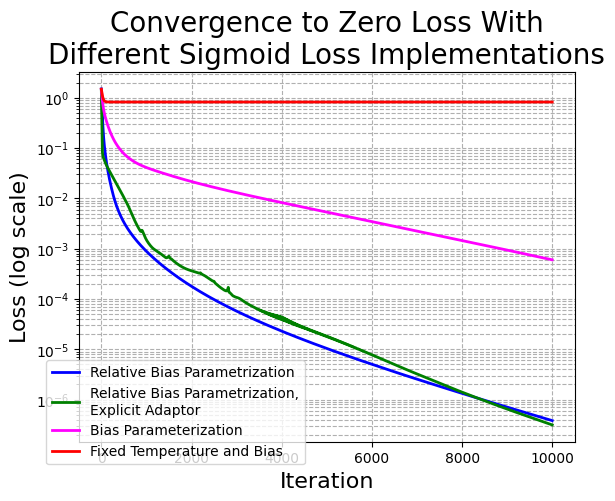

In [174]:
#plt.figure(figsize=(8, 6))
iters= np.arange(10000)
# Plot the two lines
plt.plot(iters, no_adapter_losses_history , label='Relative Bias Parametrization', linewidth=2,color = "blue")
plt.plot(iters, with_adapter_losses_history, label= 'Relative Bias Parametrization,\nExplicit Adaptor', linewidth=2,color = "green")
plt.plot(iters, no_adapter_losses_history_non_rb, label= 'Bias Parameterization', linewidth=2,color = "magenta")
plt.plot(iters, no_adapter_losses_history_non_rb_fixed, label= 'Fixed Temperature and Bias', linewidth=2,color = "red")

# Set log scale on y-axis (or use plt.xscale("log") for x-axis)
plt.yscale('log')

# Add labels and title
plt.xlabel('Iteration', fontsize = 16)
plt.ylabel('Loss (log scale)', fontsize = 16)
plt.title('Convergence to Zero Loss With\nDifferent Sigmoid Loss Implementations', fontsize = 20)
plt.legend(fontsize = 10,loc='lower left', bbox_to_anchor=(-.08, -.08))
plt.grid(True, which='both', linestyle='--')

plt.savefig('logs/losscomparisonadaptervsno.png',dpi =300,  bbox_inches='tight')
# Show the plot
plt.show()